<a href="https://colab.research.google.com/github/vivek-a81/EVA6/blob/main/Session8/session_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/MittalNeha/vision_pytorch.git

Cloning into 'vision_pytorch'...
remote: Enumerating objects: 17, done.
remote: Counting objects: 100% (17/17), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 17 (delta 2), reused 14 (delta 2), pack-reused 0
Unpacking objects: 100% (17/17), done.


In [2]:
!pip install --upgrade albumentations

     |████████████████████████████████| 102kB 3.8MB/s 
     |████████████████████████████████| 38.2MB 73kB/s 
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch 
from torchvision import datasets, transforms
from torchsummary import summary

from vision_pytorch.models import resnet
from vision_pytorch.main import *
from vision_pytorch.utils import *

In [110]:
from vision_pytorch.gradcam import GradCAM

In [109]:
import importlib
import vision_pytorch
importlib.reload(vision_pytorch.gradcam)
# importlib.reload(resnet)

<module 'vision_pytorch.gradcam' from '/content/vision_pytorch/gradcam.py'>

In [2]:
trainset, testset = download_data()

Files already downloaded and verified
Files already downloaded and verified


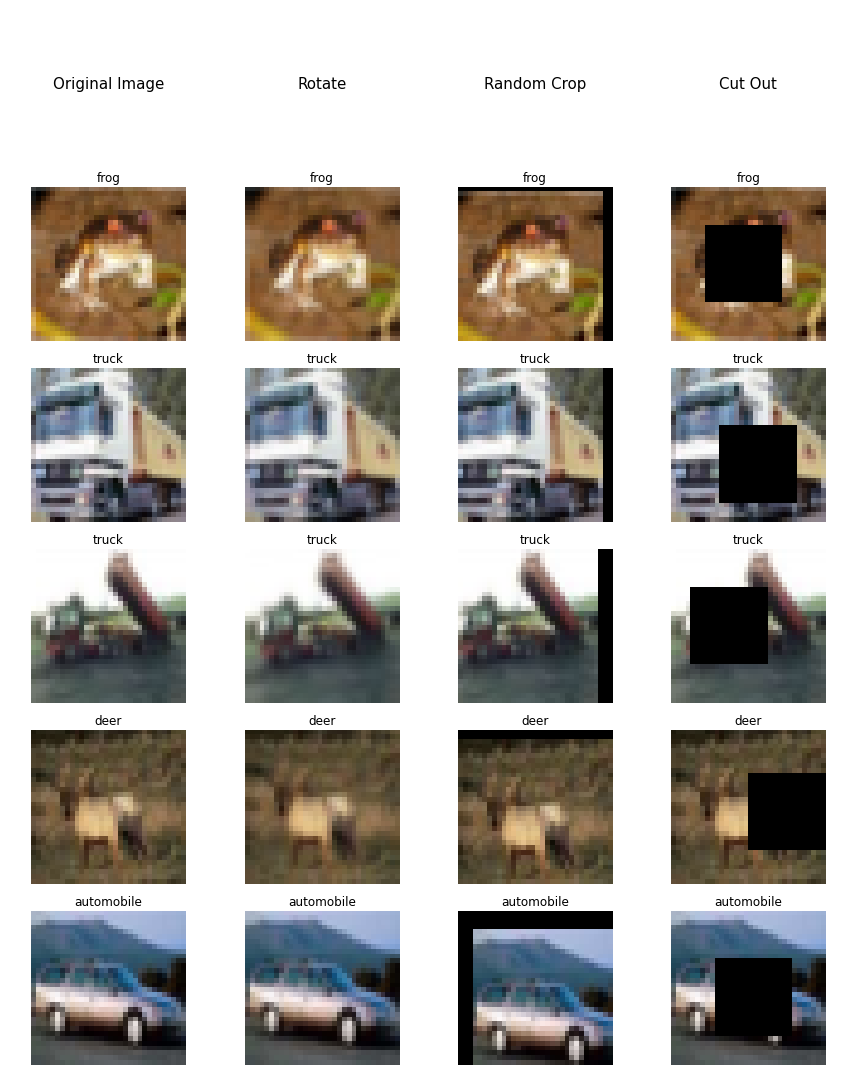

In [3]:
plot_aug({
    'Original Image': None,
    'Rotate': A.Rotate (limit=5, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=True, p=0.5),
    
    'Random Crop': A.Sequential([A.CropAndPad(px=4, keep_size=False), #padding of 2, keep_size=True by default
                A.RandomCrop(32,32)]),
    'Cut Out': A.CoarseDropout(max_holes=1, max_height=16, max_width=16, min_holes=1, min_height=16, 
                               min_width=16, fill_value=0.473363, mask_fill_value=None, always_apply=True)
}, data=trainset)

In [4]:
# Apply these transforms while training:
# RandomCrop(32, padding=4)
# CutOut(16x16)
# Rotate(±5°)

train_transform = A.Compose({
  A.Rotate (limit=5, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
  A.Sequential([A.CropAndPad(px=4, keep_size=False), #padding of 2, keep_size=True by default
                A.RandomCrop(32,32)]),
  A.CoarseDropout(1, 16, 16, 1, 16, 16,fill_value=0.473363, mask_fill_value=None),
  A.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784)),
})

test_transform = A.Compose({
  A.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784))
})

In [5]:
cuda = torch.cuda.is_available()
print("CUDA Available:", cuda)
SEED = 1
# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)
    BATCH_SIZE=64
else:
    BATCH_SIZE=32

CUDA Available: True


In [6]:
train_loader = torch.utils.data.DataLoader(LoadDataset(trainset, train_transform), batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(LoadDataset(testset, test_transform), batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=1)

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

In [8]:
net_18 = resnet.ResNet18().to(device)
summary(net_18, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
         GroupNorm-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
         GroupNorm-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
         GroupNorm-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
         GroupNorm-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
        GroupNorm-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
        GroupNorm-14          [-1, 128,

In [9]:
optimizer = torch.optim.SGD(net_18.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,mode='min', patience=8, verbose=True)

net_18, history_18 = fit_model(
    net=net_18,
    train_loader=train_loader, test_loader=test_loader,
    scheduler=scheduler, 
    optimizer=optimizer, device=device, NUM_EPOCHS=20
)

  0%|          | 0/782 [00:00<?, ?it/s]

EPOCH: 1


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.8089, Accuracy: 3064/10000 (30.64%)

EPOCH: 2


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.7614, Accuracy: 3656/10000 (36.56%)

EPOCH: 3


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.4766, Accuracy: 4463/10000 (44.63%)

EPOCH: 4


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.3111, Accuracy: 5170/10000 (51.70%)

EPOCH: 5


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.2495, Accuracy: 5361/10000 (53.61%)

EPOCH: 6


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.1999, Accuracy: 5743/10000 (57.43%)

EPOCH: 7


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0758, Accuracy: 6144/10000 (61.44%)

EPOCH: 8


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9458, Accuracy: 6662/10000 (66.62%)

EPOCH: 9


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9307, Accuracy: 6744/10000 (67.44%)

EPOCH: 10


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9114, Accuracy: 6814/10000 (68.14%)

EPOCH: 11


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8645, Accuracy: 6978/10000 (69.78%)

EPOCH: 12


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8316, Accuracy: 7119/10000 (71.19%)

EPOCH: 13


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7429, Accuracy: 7395/10000 (73.95%)

EPOCH: 14


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6584, Accuracy: 7725/10000 (77.25%)

EPOCH: 15


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6389, Accuracy: 7815/10000 (78.15%)

EPOCH: 16


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5608, Accuracy: 8088/10000 (80.88%)

EPOCH: 17


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5972, Accuracy: 7956/10000 (79.56%)

EPOCH: 18


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5637, Accuracy: 8103/10000 (81.03%)

EPOCH: 19


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5494, Accuracy: 8084/10000 (80.84%)

EPOCH: 20


Batch_id=781 Loss=0.61343 Accuracy=78.60: 100%|██████████| 782/782 [02:01<00:00,  6.46it/s]



Test set: Average loss: 0.5715, Accuracy: 8080/10000 (80.80%)



In [ ]:
torch.save(net_18.state_dict(), "resnet18.pt")

Plot the accuracy and loss curves

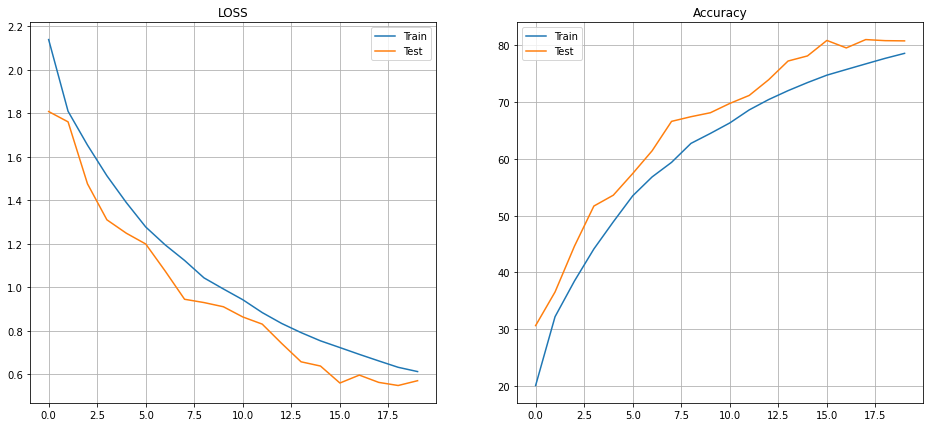

In [10]:
fig, axs = plt.subplots(1,2,figsize=(16,7))
axs[0].set_title('LOSS')
axs[0].plot(history_18[1], label='Train')
axs[0].plot(history_18[3], label='Test')
axs[0].legend()
axs[0].grid()

axs[1].set_title('Accuracy')
axs[1].plot(history_18[0], label='Train')
axs[1].plot(history_18[2], label='Test')
axs[1].legend()
axs[1].grid()

plt.show()

Load the saved model

In [ ]:
net_18.load_state_dict(torch.load("resnet18.pt"))

In [ ]:
summary(net_18,input_size = (3,32,32))

In [11]:
net_18.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): GroupNorm(1, 64, eps=1e-05, affine=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): GroupNorm(1, 64, eps=1e-05, affine=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): GroupNorm(1, 64, eps=1e-05, affine=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): GroupNorm(1, 64, eps=1e-05, affine=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): GroupNorm(1, 64, eps=1e-05, affine=True)
      (shortcut): Sequential()
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


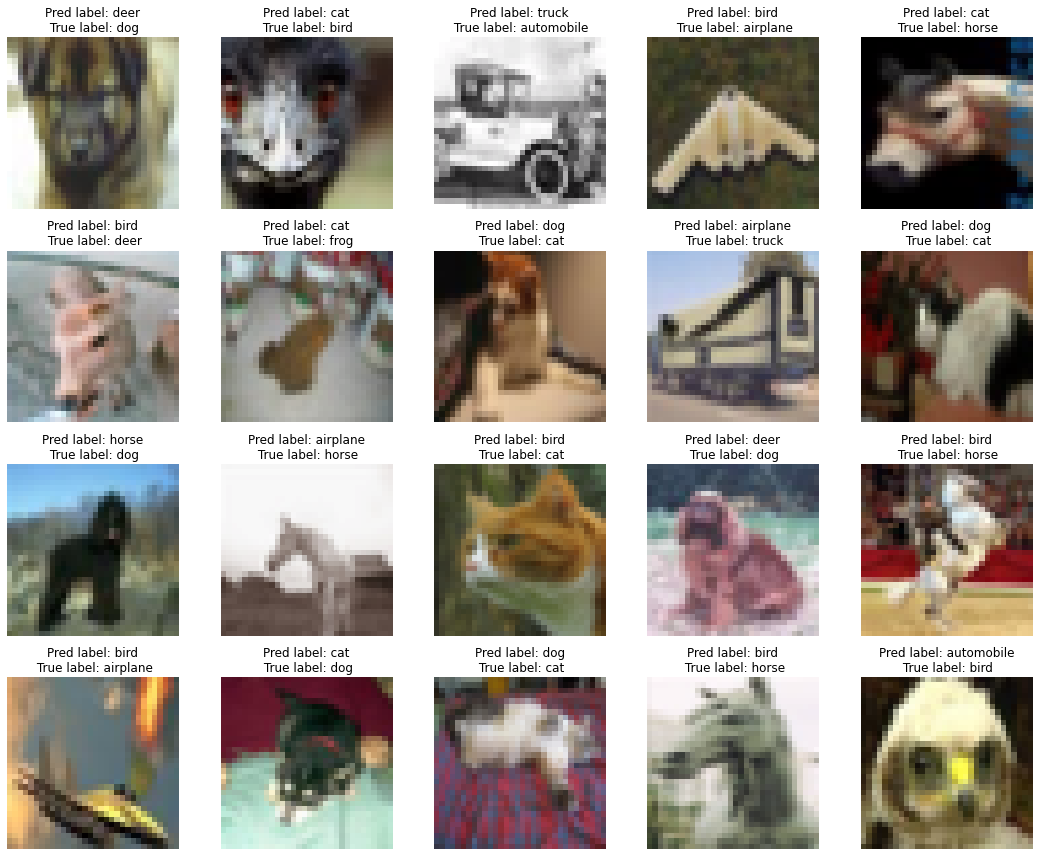

In [12]:
mean, std = np.array([0.49139968, 0.48215841, 0.44653091]), np.array([0.24703223, 0.24348513, 0.26158784])
images, labels = plot_misclassified(net_18, test_loader, testset.classes, device, mean, std, return_misclf=True)

#Load the model


In [ ]:
# net_18 = resnet.ResNet18().to(device)
# summary(net_18, input_size=(3, 32, 32))

In [ ]:
# net_18.load_state_dict(torch.load("resnet18.pt"))

# Understanding Gradcam

In [40]:
normalize = transforms.Normalize(mean, std)
n_image = []
for image in images:
    n_image.append(normalize(image))

In [119]:
inputs = torch.stack(images, dim=0)  #raw input
n_inputs = torch.stack(n_image, dim=0) #normalized input
target = torch.tensor(labels)

In [116]:
gcam = GradCAM(net_18.layer4[1])

In [ ]:
loss_fn = nn.CrossEntropyLoss()

net_18 = net_18.cpu()
out = net_18(n_inputs)
print(out.size())
err = loss_fn(out, target)
err.backward()

In [118]:
gcam.remove_hooks()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


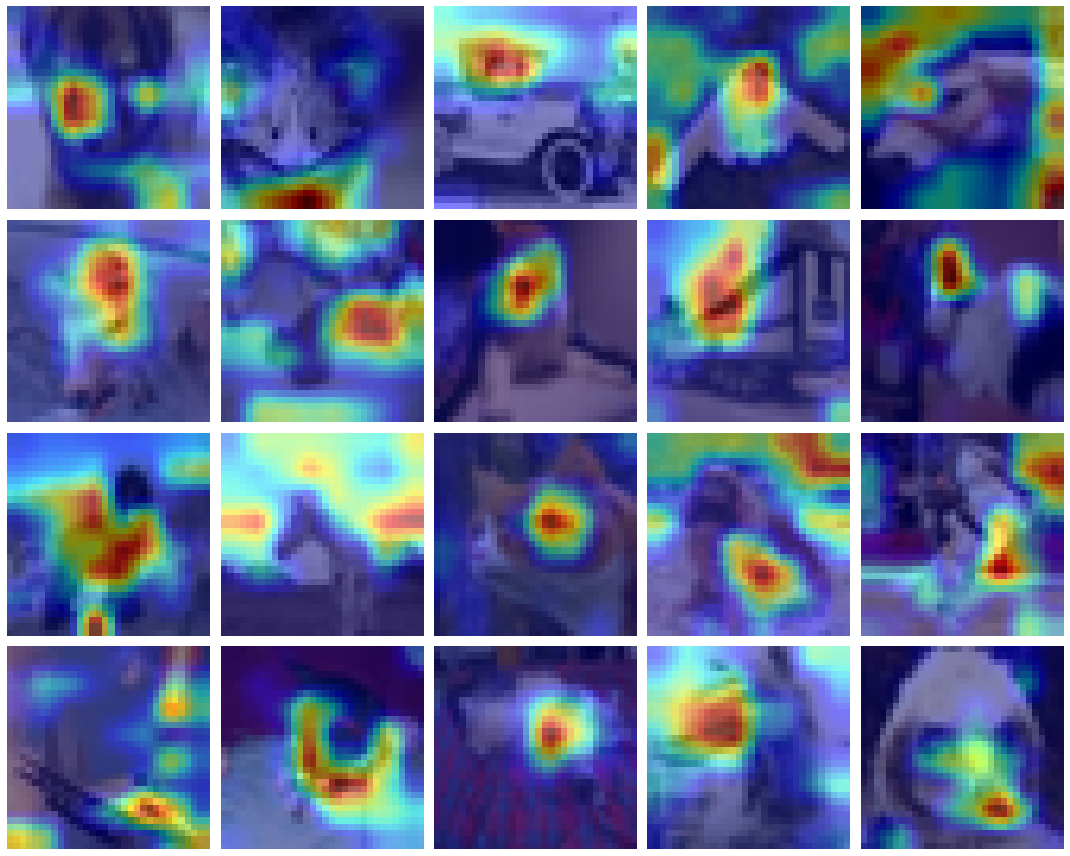

In [114]:
rows, cols = int(inputs.shape[0]/5),5
figure = plt.figure(figsize=(cols*3,rows*3))
for i in range(1, cols * rows + 1):
    # img, label, pred = misclf[i-1]

    figure.add_subplot(rows, cols, i) # adding sub plot
    # plt.title(f"Pred label: {classes[pred]}\n True label: {classes[label]}") # title of plot
    plt.axis("off") # hiding the axis
    img = gcam.generate(inputs, inputs.shape[2:], i-1)
    plt.imshow(img.squeeze(), cmap="rainbow") # showing the plot

plt.tight_layout()
plt.show()